In [1]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


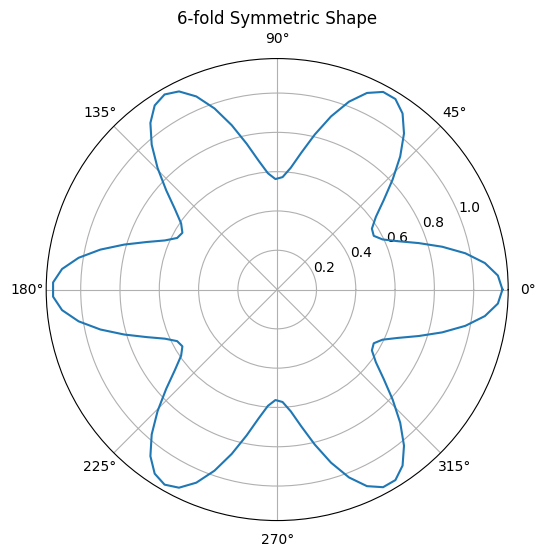

In [2]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
d = 0.8
r = 0.4
n = 6
a = 0.1
L0 = 25
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
plt.figure(figsize=(6, 6))
plt.polar(theta_values, result)
plt.title(f"{n}-fold Symmetric Shape")
plt.show()
# print(polar_to_cartesian(result, theta_values))

In [38]:
ctlpts = np.array([[0.48555564880371094, 0.461707204580307, 0.4488178491592407, 0.4529491364955902, 
           0.45946311950683594, 0.4788070619106293, 0.4872964322566986, 0.4816374182701111, 
           0.4854227602481842, 0.4902132451534271, 0.49531835317611694, 0.507867693901062,
           0.5346999168395996, 0.5879551768302917, 0.7011892795562744, 0.6726462244987488,
           0.46186813712120056, 0.3711071014404297, 0.3387696146965027, 0.26965463161468506,
           0.09419172257184982, -0.08759941905736923, 0.18708324432373047, 0.19953271746635437,
           -0.0013188637094572186, -0.05136439576745033, 0.3346371352672577, 0.47256091237068176,
           0.796478807926178, 0.5115493535995483, 0.4795879125595093, 0.48260465264320374],
          [0.003558018244802952, -0.0030079197604209185, -0.0057970271445810795, -0.00400342233479023,
           -0.006246759090572596, -0.006358697544783354, 2.5723129510879517e-06, -0.0004138620279263705,
           0.012208137661218643, 0.01625647582113743, 0.03646162524819374, 0.06094575300812721,
           0.0949007198214531, 0.16090194880962372, 0.3151451051235199, 0.37135884165763855,
           0.21077172458171844, 0.1590133011341095, 0.13978002965450287, 0.15379546582698822,
           0.332438588142395, 0.38076522946357727, 0.037919897586107254, -0.03015035204589367,
           -0.1979031264781952, -0.44769662618637085, -0.12772612273693085, -0.25168296694755554,
           -0.43906649947166443, -0.08002528548240662, -0.011266911402344704, 0.0026920977979898453]])
weights = np.array([0.10123608261346817, 0.09858367592096329, 0.10119597613811493, 0.09971634298563004,
           0.09576867520809174, 0.09801937639713287, 0.13111865520477295, 0.09775735437870026,
           0.12425547093153, 0.08091424405574799, 0.09052342921495438, 0.09468352049589157,
           0.07757404446601868, 0.05204970762133598, 0.032695792615413666, 0.03474508225917816,
           0.0779278427362442, 0.13388802111148834, 0.14278794825077057, 0.09959631413221359,
           0.037657059729099274, 0.06631699204444885, 0.1726970076560974, 0.11162034422159195,
           0.0279964879155159, 0.0565689317882061, 0.15092866122722626, 0.01478570606559515,
           0.032932814210653305, 0.06922388076782227, 0.1949511617422104, 0.0984344482421875])

In [32]:
ctlpts = np.array([[0.4945697784423828, 0.4863211214542389, 0.4901614785194397, 0.509587824344635, 
           0.5258923172950745, 0.5478668212890625, 0.5569302439689636, 0.4842439293861389,
           0.4300110638141632, 0.34704163670539856, 0.3117505609989166, 0.2896122336387634,
           0.25792765617370605, 0.20764131844043732, 0.10684122145175934, -0.025508040562272072,
           -0.023301197215914726, 0.13246791064739227, 0.22284379601478577, 0.2544543743133545,
           0.27830368280410767, 0.30574706196784973, 0.3374943137168884, 0.4015735387802124,
           0.4509890377521515, 0.5557920336723328, 0.5545370578765869, 0.5262722373008728,
           0.528229832649231, 0.4955866038799286, 0.4930431842803955, 0.5043909549713135],
            [0.006959728430956602, 0.01239315327256918, 0.03743232786655426, 0.07845724374055862, 
             0.12131121009588242, 0.20895498991012573, 0.32904645800590515, 0.3210972845554352, 
             0.2605370581150055, 0.18598805367946625, 0.1483028382062912, 0.12147330492734909, 
             0.11096946150064468, 0.09714686125516891, 0.08834633976221085, 0.02548958547413349, 
             -0.03300272673368454, -0.07940245419740677, -0.09394693374633789, -0.10086223483085632, 
             -0.11003636568784714, -0.1330055147409439, -0.16766637563705444, -0.22875435650348663, 
             -0.2886456847190857, -0.33983439207077026, -0.18895328044891357, -0.11168479919433594, 
             -0.09326477348804474, -0.033122718334198, 0.0001156926155090332, 0.006309317424893379]])
weights = np.array([0.0025300905108451843, 0.00357867986895144, 0.0037845997139811516, 0.002744589699432254,
            0.0023298030719161034, 0.0017924911808222532, 0.0013510570861399174, 0.0007019041804596782,
            0.0013908531982451677, 0.003288048319518566, 0.004029596224427223, 0.00428433483466506,
            0.003543122671544552, 0.0042422316037118435, 0.00375157268717885, 0.0034774953965097666,
            0.0032558708917349577, 0.00624815421178937, 0.005322189535945654, 0.002714200410991907,
            0.004167245700955391, 0.005131041165441275, 0.0038470199797302485, 0.0018886413890868425,
            0.0012587191304191947, 0.001832924666814506, 0.0016237969975918531, 0.00048126012552529573,
            0.0017591043142601848, 0.005036474205553532, 0.003983697853982449, 0.0024836729280650616])

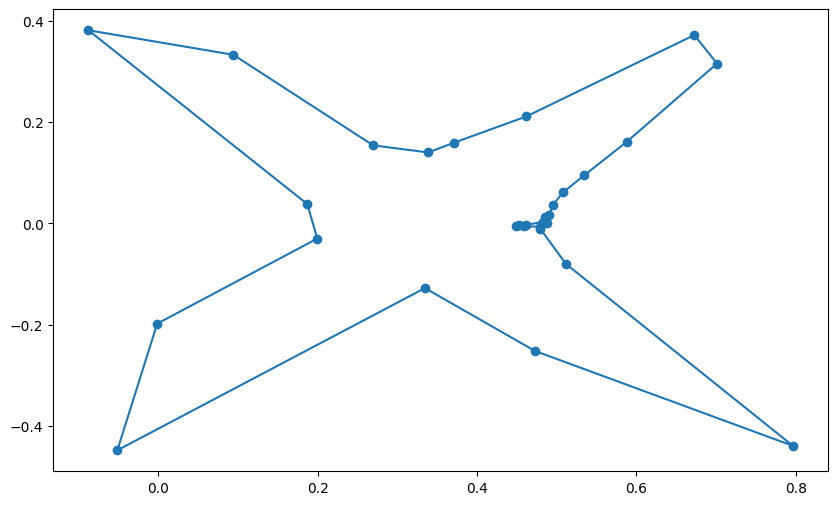

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(ctlpts.transpose()[:, 0], ctlpts.transpose()[:, 1], 'o-', label='32x2 Data')

(32,)

In [33]:
weights.shape

(32,)

32
2
(32,)


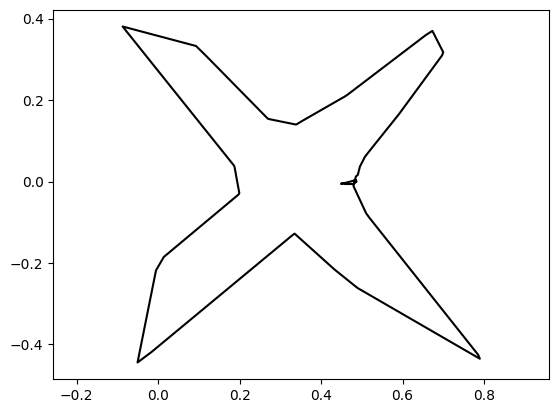

In [40]:
from pyiga.geometry import *
from pyiga import approx, bspline
n_kv = 31
kv = bspline.make_knots(1, 0.0, 1.0, n_kv)
# N = tuple(kv.numdofs for kv in kvs)
r = 2.0
num_res = kv.numdofs
print(num_res)
# construct quarter circle using NURBS
theta_values = np.linspace(0, 2 * np.pi, num_res)
result = superformula(theta_values, r, d, n, a, L0)
coeff = np.array(polar_to_cartesian(result, theta_values)).transpose()
# w = np.ones((1,num_res))
# coeff = np.vstack((coeff, w)).transpose()
coeff = ctlpts.transpose()
grid = (np.linspace(0.0, 1.0, 200),)
print(coeff.shape[1])
weights = weights.transpose()
# weights = np.random.random(coeff.shape[0])*5
# weights = np.ones(coeff.shape[0])
N = tuple(kv.numdofs for kv in (kv,))
print(N)
nurbs = NurbsFunc((kv,), coeff.copy(), weights=weights)
vals = nurbs.grid_eval(grid)
vis.plot_geo(nurbs,res=500, linewidth=None, color='black')
axis('equal');


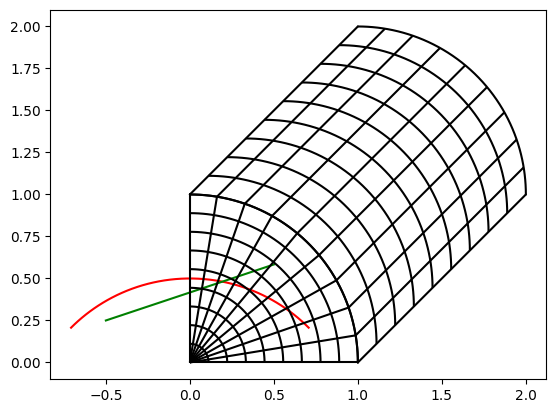

In [35]:
f = geometry.circular_arc(pi/2)
g = geometry.line_segment([0,0], [1,1])
vis.plot_geo(f.rotate_2d(pi/4).translate([0,-0.5]), color='red')
vis.plot_geo(g.scale([1,1/3]).translate([-.5,.25]), color='green')
axis('equal');
vis.plot_geo(geometry.outer_sum(f, g))
axis('equal');
vis.plot_geo(geometry.outer_product(f, g))
axis('equal');


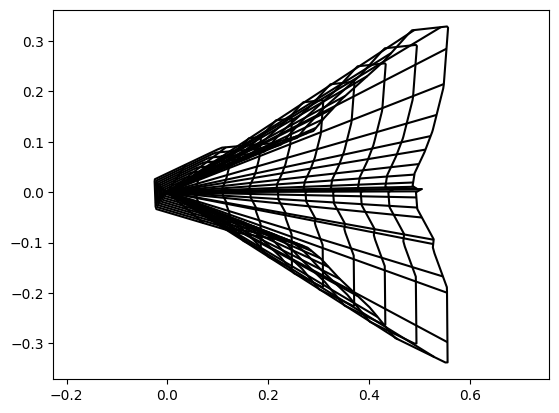

In [37]:
g = geometry.line_segment([0,0], [1,1], intervals=100)
geo = geometry.outer_product(nurbs, g)
grid = (np.linspace(0.0, 1.0, 8),)
vis.plot_geo(geo, gridx = 50, gridy = 10, grid = grid, res = 400)
axis('equal');

In [7]:
geo.coeffs.shape

(10, 101, 3)

In [8]:
geo.kvs

(KnotVector(array([0.        , 0.        , 0.11111111, 0.22222222, 0.33333333,
        0.44444444, 0.55555556, 0.66666667, 0.77777778, 0.88888889,
        1.        , 1.        ]), 1),
 KnotVector(array([0.  , 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
        0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
        0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
        0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
        0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
        0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
        0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
        0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
        0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
        0.98, 0.99, 1.  , 1.  ]), 1))

In [9]:
geo.coeffs.shape

(10, 101, 3)

In [10]:
g = lambda x,y: np.exp(-(x-.8)**2 - (y-.8)**2)  # Dirichlet BC function
f = lambda x,y: 3 * np.sin(10*x) * np.cos(10*y) # source term
kvs = geo.kvs
# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('right', g), ('top', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo, res = 10000)
gca().set_aspect('equal')
colorbar();

Error in callback <function _draw_all_if_interactive at 0x000001D6EBEBEE50> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001D6EBEBE3A0> (for post_execute):


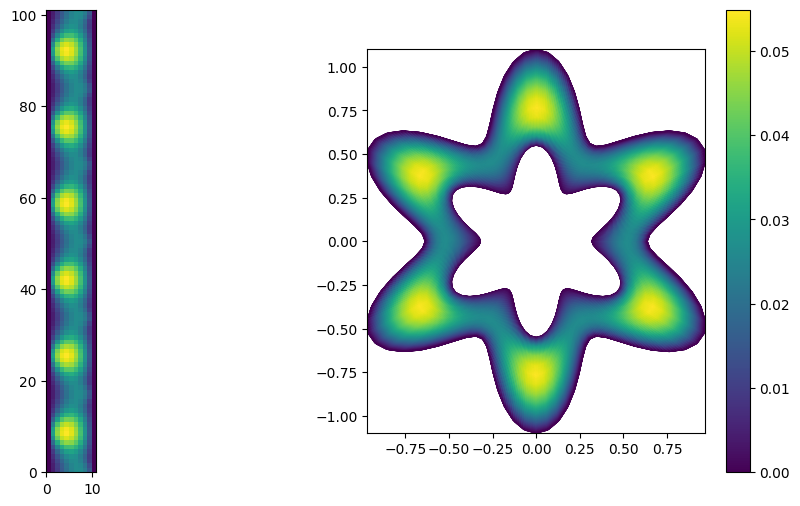

In [ ]:
g = lambda x,y: 0  # Dirichlet BC function
f = lambda x,y: 3 # source term

# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('left', g), ('right', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo, res = 500)
gca().set_aspect('equal')
colorbar();

In [ ]:
u.shape

(909,)